# Fake News Detector

The purpose of this project is to create a webapp that gives a fake news rating to articles linked to it by the user. To accomplish this we will need to:
- Create a model that can run in a webapp and converts processed text into a fake news confidence rating.
- Create a system that automatically scrapes the relevant text from any given news article and then processes it into an ingestible form for the model

In [1]:
import kagglehub

#import dataset from kaggle
# path1 = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")
# print("Path to dataset files:", path1)

In [1]:
import pandas as pd

#load data
dftrue = pd.read_csv("C:/Users/David/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1/true.csv")
dffake = pd.read_csv("C:/Users/David/.cache/kagglehub/datasets/clmentbisaillon/fake-and-real-news-dataset/versions/1/fake.csv")

#add columns to label the real and fake articles
dftrue['label'] = 1
dffake['label'] = 0

#combine
df = pd.concat([dftrue, dffake], ignore_index=True)

df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


Date range: From 14-Feb-18 to https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg
Minimum character count: 1
Maximum character count: 51794
Average character count: 2469.11
Number of rows: 44898


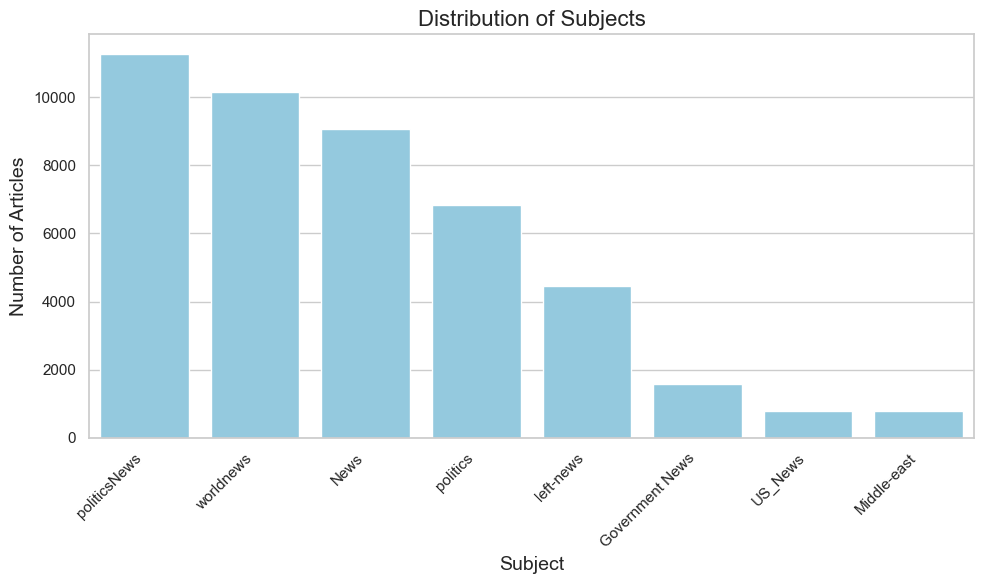

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
def EDA(df):
#find date ranges
    min_date = df['date'].min()
    max_date = df['date'].max()
    print(f"Date range: From {min_date} to {max_date}")

#find article ranges
    text_lengths = df['text'].str.len()
    min_length = text_lengths.min()
    max_length = text_lengths.max()
    avg_length = text_lengths.mean()
    print(f"Minimum character count: {min_length}")
    print(f"Maximum character count: {max_length}")
    print(f"Average character count: {avg_length:.2f}")

    subject_distribution = df['subject'].value_counts()

#find number of rows  
    num_rows = len(df)
    print(f"Number of rows: {num_rows}")
    
# Set the theme for seaborn
    sns.set_theme(style="whitegrid")

# Plot the bar chart using seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=subject_distribution.index, y=subject_distribution.values, color='skyblue')

# Add labels and title
    plt.title('Distribution of Subjects', fontsize=16)
    plt.xlabel('Subject', fontsize=14)
    plt.ylabel('Number of Articles', fontsize=14)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Display the plot
    plt.tight_layout()
    plt.show()

EDA(df)

Date range: From 2016-01-13 00:00:00 to 2017-12-31 00:00:00
Minimum character count: 1000
Maximum character count: 51794
Average character count: 2994.76
Number of rows: 35446


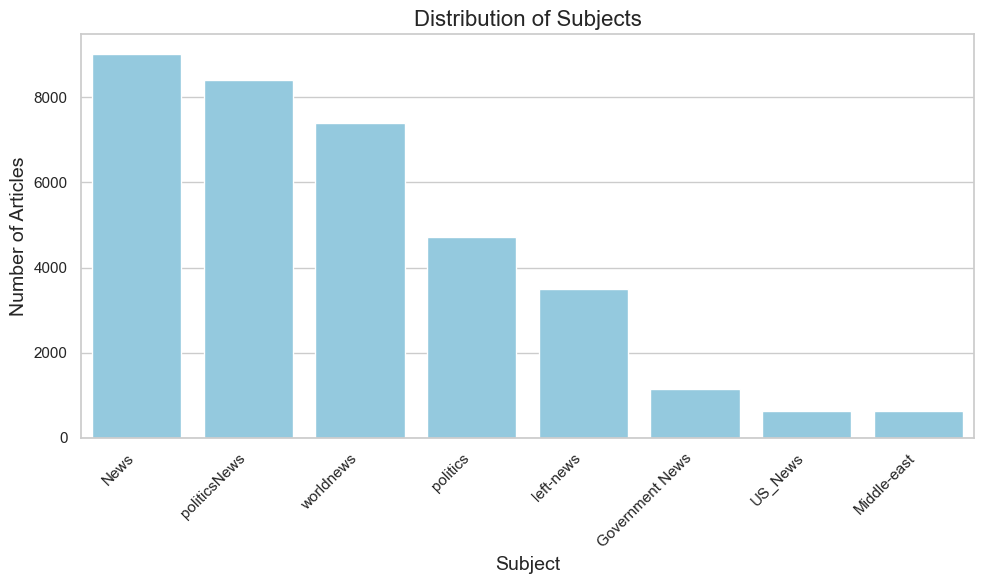

In [3]:
# Convert the 'date' column to datetime, invalid dates will become NaT
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows where the 'text' column has fewer than 50 characters
df = df[df['text'].str.len() >= 1000]

EDA(df)

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import RobertaTokenizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize NLTK objects
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Initialize RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def preprocess_text(text):
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Apply lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    # Remove excessive whitespace
    text = ' '.join(text.split())
    
    return text

def tokenize_text(text):
    # Tokenize text using RoBERTa tokenizer
    return tokenizer(text, padding=True, truncation=True, return_tensors='pt')

# Example usage with a pandas dataframe
# Assuming your dataframe is named `df`
df['combined_text'] = df['title'] + " " + df['text']
df['processed_text'] = df['combined_text'].apply(preprocess_text)
df['tokenized_text'] = df['processed_text'].apply(tokenize_text)

# Display the preprocessed dataframe
print(df.head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject       date  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews 2017-12-31   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews 2017-12-29   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews 2017-12-31   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews 2017-12-30   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews 2017-12-29   

   label                                      combined_text  \
0      1  As U.S. budget fight looms, Republicans flip t...   
1      1  U.S. military to accept transgender recr

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\David\anaconda3\envs\jupyter-ai\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


No saved model found. Starting training from scratch.
Epoch 1/5


C:\Users\David\AppData\Local\Temp\ipykernel_2856\2985579920.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Training loss: 0.029176639823603627
Training F1: 0.9881838074398249, Training Accuracy: 0.9895260262378333


C:\Users\David\AppData\Local\Temp\ipykernel_2856\2985579920.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Validation loss: 0.005441166707831078
Validation F1: 0.9985802176999526, Validation Accuracy: 0.9987306064880113
Model saved to saved_models\epoch_1.pt
Epoch 2/5


C:\Users\David\AppData\Local\Temp\ipykernel_2856\2985579920.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Training loss: 0.007515891045136452
Training F1: 0.9978583326723249, Training Accuracy: 0.9980956411341515


C:\Users\David\AppData\Local\Temp\ipykernel_2856\2985579920.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Validation loss: 0.003871124886204557
Validation F1: 0.9992124744054182, Validation Accuracy: 0.9992947813822285
Model saved to saved_models\epoch_2.pt
Epoch 3/5


C:\Users\David\AppData\Local\Temp\ipykernel_2856\2985579920.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Training loss: 0.004720599735006817
Training F1: 0.9989692356485886, Training Accuracy: 0.9990830864719988


C:\Users\David\AppData\Local\Temp\ipykernel_2856\2985579920.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Validation loss: 0.012564695412505456
Validation F1: 0.9982641628530851, Validation Accuracy: 0.9984485190409027
Model saved to saved_models\epoch_3.pt
Epoch 4/5


C:\Users\David\AppData\Local\Temp\ipykernel_2856\2985579920.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Training loss: 0.016540203069338878
Training F1: 0.9963152264352787, Training Accuracy: 0.9967202708421498


C:\Users\David\AppData\Local\Temp\ipykernel_2856\2985579920.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Validation loss: 0.037256233173048624
Validation F1: 0.9932527851875098, Validation Accuracy: 0.993935119887165
Model saved to saved_models\epoch_4.pt
Epoch 5/5


C:\Users\David\AppData\Local\Temp\ipykernel_2856\2985579920.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Training loss: 0.0144064217224426
Training F1: 0.9969086873811034, Training Accuracy: 0.9972492594159966


C:\Users\David\AppData\Local\Temp\ipykernel_2856\2985579920.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Validation loss: 0.012313200978652432
Validation F1: 0.9970017358371469, Validation Accuracy: 0.9973201692524682
Model saved to saved_models\epoch_5.pt


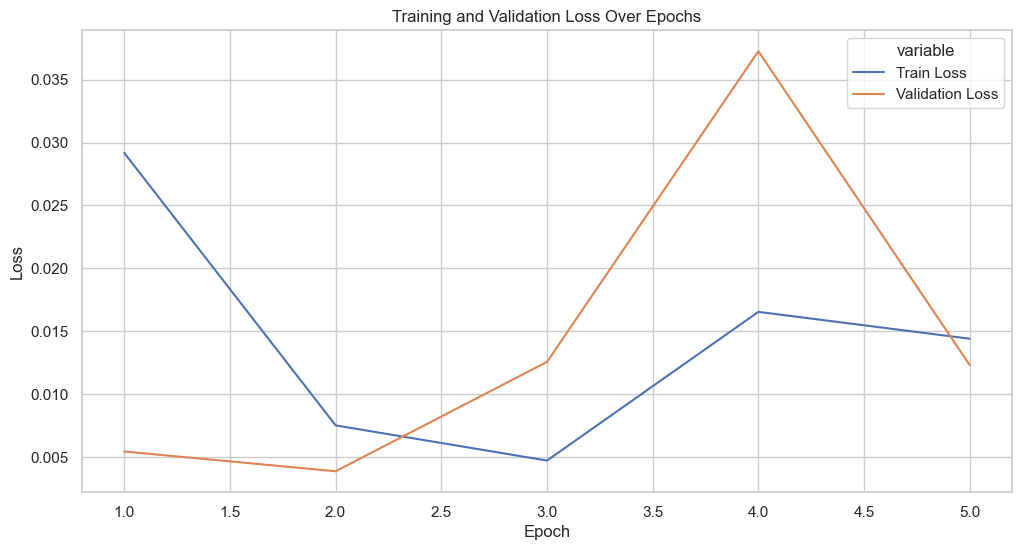

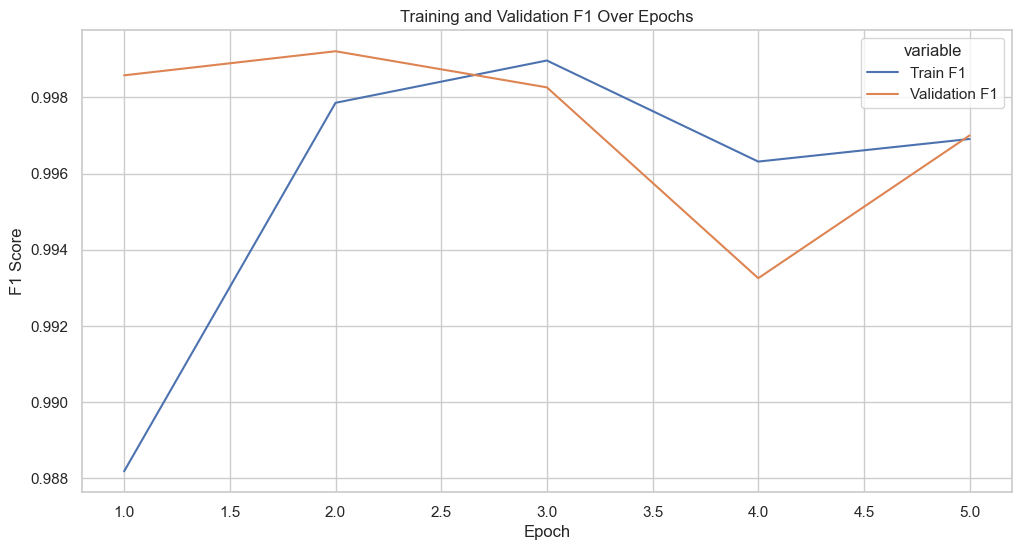

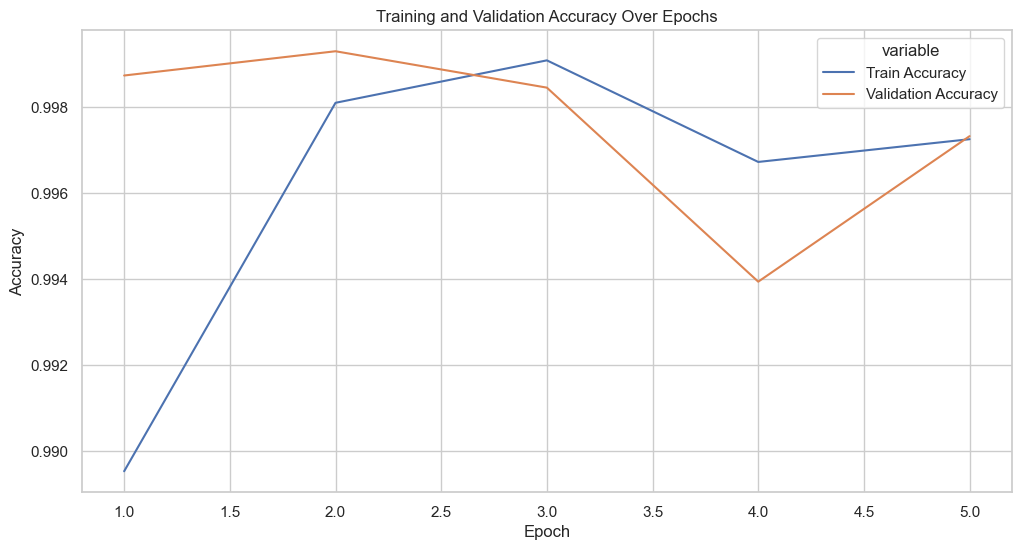

In [5]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Prepare the tokenized text for training
class NewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Split the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['processed_text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Tokenize the training and validation texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')

# Create PyTorch datasets
train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

# Create PyTorch data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Step 2: Download and load the pre-trained RoBERTa model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Step 3: Set up the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Function to compute evaluation metrics
def compute_metrics(preds, labels):
    preds = torch.argmax(preds, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    f1 = f1_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {'f1': f1, 'accuracy': acc}

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_f1s = []
val_f1s = []
train_accs = []
val_accs = []

# Step 4: Check for a saved model and load it if it exists
model_save_dir = 'saved_models'
os.makedirs(model_save_dir, exist_ok=True)  # Create directory if it doesn't exist

latest_checkpoint = None
for checkpoint in sorted(os.listdir(model_save_dir), reverse=True):
    if checkpoint.startswith('epoch_'):
        latest_checkpoint = checkpoint
        break

if latest_checkpoint:
    checkpoint_path = os.path.join(model_save_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_f1s = checkpoint['train_f1s']
    val_f1s = checkpoint['val_f1s']
    train_accs = checkpoint['train_accs']
    val_accs = checkpoint['val_accs']
    print(f"Resuming training from epoch {start_epoch} (loaded from {checkpoint_path})")
else:
    start_epoch = 0
    print("No saved model found. Starting training from scratch.")

# Step 5: Training loop
def train(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Collect predictions and labels
        logits = outputs.logits
        all_preds.append(logits.detach())
        all_labels.append(labels.detach())
        
        loss.backward()
        optimizer.step()
    
    # Compute metrics
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    metrics = compute_metrics(all_preds, all_labels)
    
    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)
    train_f1s.append(metrics['f1'])
    train_accs.append(metrics['accuracy'])
    
    print(f"Training loss: {avg_loss}")
    print(f"Training F1: {metrics['f1']}, Training Accuracy: {metrics['accuracy']}")

# Step 6: Validation loop
def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            # Collect predictions and labels
            logits = outputs.logits
            all_preds.append(logits.detach())
            all_labels.append(labels.detach())
    
    # Compute metrics
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    metrics = compute_metrics(all_preds, all_labels)
    
    avg_loss = total_loss / len(dataloader)
    val_losses.append(avg_loss)
    val_f1s.append(metrics['f1'])
    val_accs.append(metrics['accuracy'])
    
    print(f"Validation loss: {avg_loss}")
    print(f"Validation F1: {metrics['f1']}, Validation Accuracy: {metrics['accuracy']}")

# Step 7: Run training and validation
epochs = 5
for epoch in range(start_epoch, epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    train(model, train_loader, optimizer, loss_fn, device)
    evaluate(model, val_loader, loss_fn, device)
    
    # Save the model after each epoch
    checkpoint_path = os.path.join(model_save_dir, f'epoch_{epoch + 1}.pt')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'train_accs': train_accs,
        'val_accs': val_accs
    }, checkpoint_path)
    print(f"Model saved to {checkpoint_path}")

# Step 8: Plot the metrics
metrics_df = pd.DataFrame({
    'Epoch': range(1, len(train_losses) + 1),
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Train F1': train_f1s,
    'Validation F1': val_f1s,
    'Train Accuracy': train_accs,
    'Validation Accuracy': val_accs
})

# Plot Loss
plt.figure(figsize=(12, 6))
sns.lineplot(x='Epoch', y='value', hue='variable', 
             data=pd.melt(metrics_df, id_vars=['Epoch'], value_vars=['Train Loss', 'Validation Loss']))
plt.title('Training and Validation Loss Over Epochs')
plt.ylabel('Loss')
plt.show()

# Plot F1
plt.figure(figsize=(12, 6))
sns.lineplot(x='Epoch', y='value', hue='variable', 
             data=pd.melt(metrics_df, id_vars=['Epoch'], value_vars=['Train F1', 'Validation F1']))
plt.title('Training and Validation F1 Over Epochs')
plt.ylabel('F1 Score')
plt.show()

# Plot Accuracy
plt.figure(figsize=(12, 6))
sns.lineplot(x='Epoch', y='value', hue='variable', 
             data=pd.melt(metrics_df, id_vars=['Epoch'], value_vars=['Train Accuracy', 'Validation Accuracy']))
plt.title('Training and Validation Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.show()